<a href="https://colab.research.google.com/github/SANJU00ALLY/Event/blob/main/ML_CW00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setting up the Environment/ Data Loading**

In [11]:
#Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn for preprocessing and metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# Tensorflow/Keras for Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Setting style for visuals
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Using google drive to import the dataset (useful when opening though GIT)
# Load Data
from google.colab import drive
drive.mount('/content/drive/')
try:
    df = pd.read_csv('/content/drive/MyDrive/ML_Coursework/WA_Fn-UseC_-Telco-Customer-Churn.csv')
    print("Dataset Loaded Successfully.")
except FileNotFoundError:
    print("Error: File not found. Please upload the CSV.")

# Look at the raw data
df.head()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Dataset Loaded Successfully.


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**Data Cleaning and Preprocessing**

In [12]:
# Data Cleaning

# 1. Drop ID column (adds no predictive value)
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)

# 2. Fix 'TotalCharges': It's object type but should be numeric.
# Errors='coerce' turns empty strings into NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 3. Handle Nulls
# Check how many rows became NaN
print(f"Missing values in TotalCharges: {df['TotalCharges'].isnull().sum()}")

# Drop them safelydue to lower missing outputs.
df.dropna(inplace=True)

# 4. Target Variable Setup
# Change 'Yes'/'No' to 1/0 for the 'Churn' column (numeric)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

print("Data Cleaning Complete. Shape:", df.shape)

Missing values in TotalCharges: 11
Data Cleaning Complete. Shape: (7032, 20)


**Task 01 - Exploratory Data Analysis(EDA)**

/tmp/ipython-input-2535262487.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette='viridis')


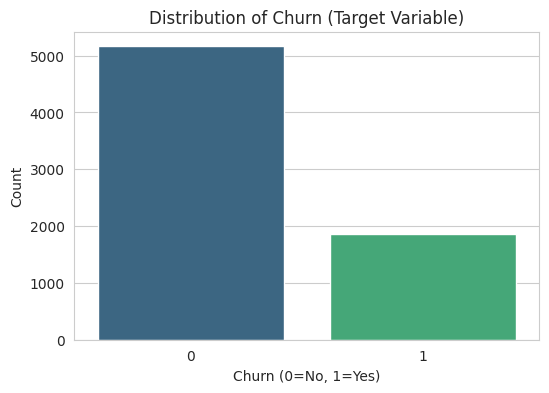

Churn Rate: 26.58%


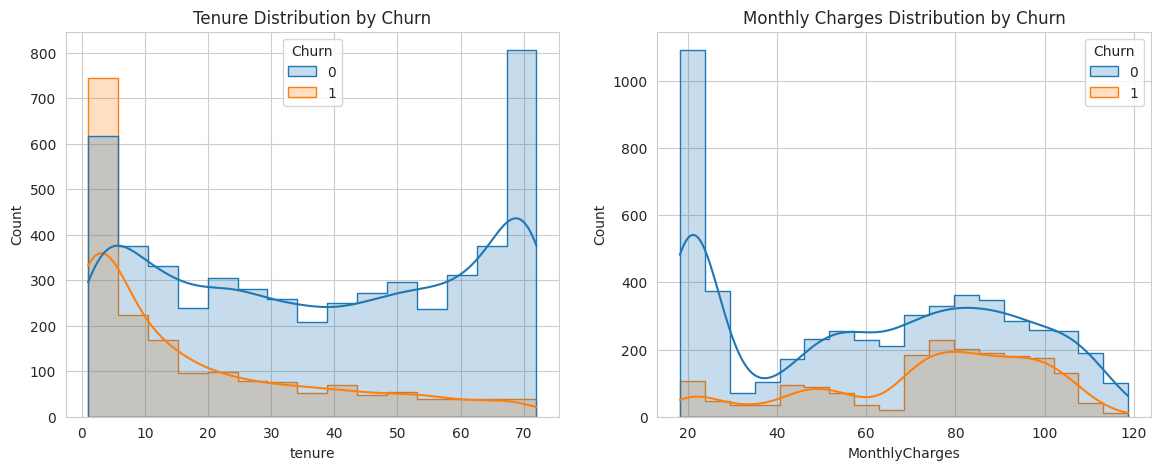

/tmp/ipython-input-2535262487.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_name, y='Churn', data=df, palette='coolwarm', errorbar=None)


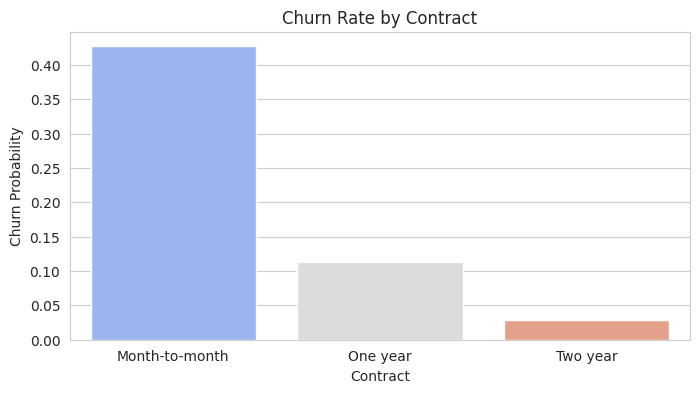

/tmp/ipython-input-2535262487.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_name, y='Churn', data=df, palette='coolwarm', errorbar=None)


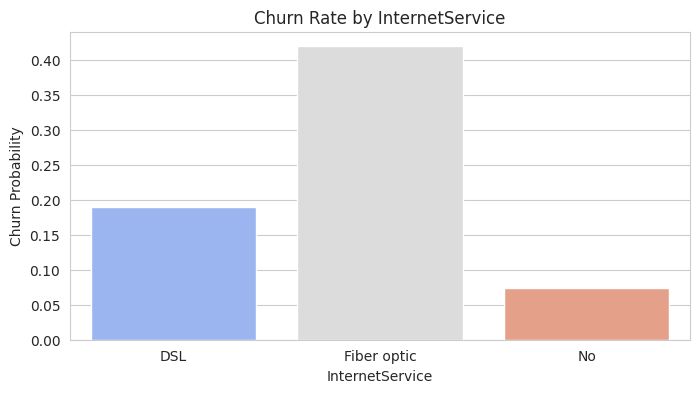

/tmp/ipython-input-2535262487.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_name, y='Churn', data=df, palette='coolwarm', errorbar=None)


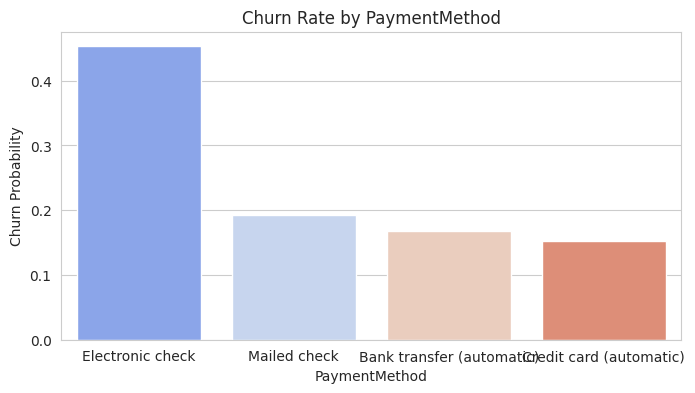

In [13]:
# Exploratory Data Analysis (EDA)

# Target Class Balance
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df, palette='viridis')
plt.title('Distribution of Churn (Target Variable)')
plt.xlabel('Churn (0=No, 1=Yes)')
plt.ylabel('Count')
plt.show()
print(f"Churn Rate: {round(df['Churn'].mean() * 100, 2)}%")

# Numerical Feature Distribution (Tenure & MonthlyCharges)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(data=df, x='tenure', hue='Churn', kde=True, element="step", ax=ax[0])
ax[0].set_title('Tenure Distribution by Churn')
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', kde=True, element="step", ax=ax[1])
ax[1].set_title('Monthly Charges Distribution by Churn')
plt.show()

# Categorical correlations
# Custom function to visualize categorical features vs Churn
def plot_churn_by_category(feature_name):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=feature_name, y='Churn', data=df, palette='coolwarm', errorbar=None)
    plt.title(f'Churn Rate by {feature_name}')
    plt.ylabel('Churn Probability')
    plt.show()

# Visualize key categorical features
plot_churn_by_category('Contract')
plot_churn_by_category('InternetService')
plot_churn_by_category('PaymentMethod')

**Feature Engineering & Splitting**

In [14]:
# Feature Engineering & Splitting

# Identify column types
categorical_cols = [c for c in df.columns if df[c].dtype == 'object']
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Create variables for categorical columns (One Hot Encoding)
df_processed = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Define X and y
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']

# Split data (80% Train, 20% Test)
# Using a specific random_state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature Scaling
# Neural Networks require scaling. Decision Trees don't strictly need it, but it helps convergence.
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training Data Shape:", X_train_scaled.shape)
print("Testing Data Shape:", X_test_scaled.shape)

Training Data Shape: (5625, 30)
Testing Data Shape: (1407, 30)


**Task 02 - Decision Tree**

In [15]:
# Decision Tree Classifier with Tuning

# Define the model
dt = DecisionTreeClassifier(random_state=42)

# Hyperparameter Grid
# Parameters - control overfitting (max_depth, min_samples)
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Run Grid Search
print("Starting Grid Search for Decision Tree...")
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get best model
best_dt_model = grid_search.best_estimator_

print("Best Parameters found:", grid_search.best_params_)

# Predictions
y_pred_dt = best_dt_model.predict(X_test_scaled)
y_prob_dt = best_dt_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("\n--- Decision Tree Report ---")
print(classification_report(y_test, y_pred_dt))

Starting Grid Search for Decision Tree...
Best Parameters found: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}

--- Decision Tree Report ---
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1033
           1       0.58      0.60      0.59       374

    accuracy                           0.78      1407
   macro avg       0.72      0.72      0.72      1407
weighted avg       0.78      0.78      0.78      1407



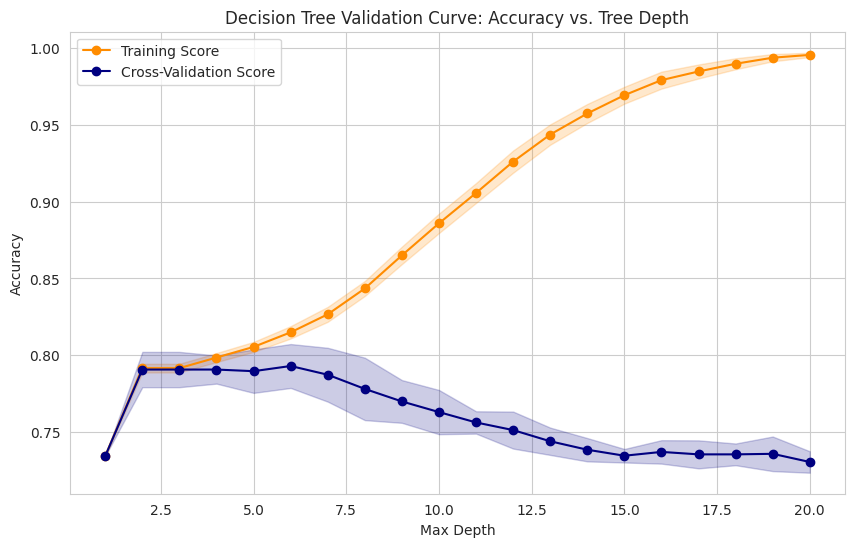

In [16]:
# Decision Tree Complexity Graph (Validation Curve)
from sklearn.model_selection import validation_curve

# Define the range of tree depths to test
param_range = np.arange(1, 21)

# Calculate scores for training and test sets
train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(random_state=42),
    X_train_scaled, y_train,
    param_name="max_depth",
    param_range=param_range,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

# Calculate mean and standard deviation for plotting
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training Score", color="darkorange", marker='o')
plt.plot(param_range, test_mean, label="Cross-Validation Score", color="navy", marker='o')

# Fill the area around the line to show variance
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="darkorange")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.2, color="navy")

plt.title("Decision Tree Validation Curve: Accuracy vs. Tree Depth")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

**Task 02 - Neural Network**

In [17]:
# Neural Network Model

# Define the Neural Network Architecture
def build_ann():
    model = Sequential([
        # Input layer
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(0.3), # Regularization to prevent overfitting

        # Hidden layer
        Dense(32, activation='relu'),
        Dropout(0.2),

        # Output layer (Sigmoid for binary classification)
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

ann_model = build_ann()

# Early stopping to prevent wasted epochs
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

# Train the model
history = ann_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    batch_size=32,
    epochs=100,
    callbacks=[early_stop],
    verbose=1
)

# Predictions
y_pred_ann_prob = ann_model.predict(X_test_scaled)
y_pred_ann = (y_pred_ann_prob > 0.5).astype(int).flatten() # Convert probabilities to binary class

print("\n--- Neural Network Report ---")
print(classification_report(y_test, y_pred_ann))

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.6837 - loss: 0.5638 - val_accuracy: 0.7953 - val_loss: 0.4396
Epoch 2/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7819 - loss: 0.4461 - val_accuracy: 0.7932 - val_loss: 0.4374
Epoch 3/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7864 - loss: 0.4357 - val_accuracy: 0.7932 - val_loss: 0.4360
Epoch 4/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7938 - loss: 0.4404 - val_accuracy: 0.7939 - val_loss: 0.4355
Epoch 5/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7969 - loss: 0.4305 - val_accuracy: 0.7932 - val_loss: 0.4343
Epoch 6/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8060 - loss: 0.4138 - val_accuracy: 0.7960 - val_loss: 0.4339
Epoch 7/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8091 - loss: 0.4100 - val_accuracy: 0.7925 - val_loss: 0.4342
Epoch 8/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8060 - loss: 0.4162 - val_accuracy: 0.792

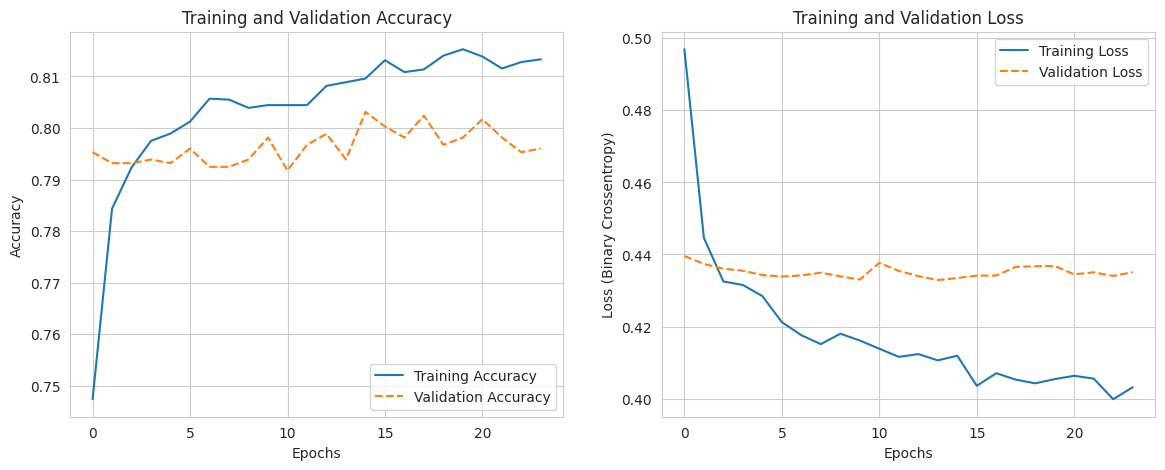

In [18]:
# Visualize Training History (Accuracy & Loss)

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Plot 1: Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', linestyle='--')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot 2: Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss', linestyle='--')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Binary Crossentropy)')
    plt.legend(loc='upper right')

    plt.show()

# Generate the plots
plot_training_history(history)

**Task 02 - Comparison & Evaluation**

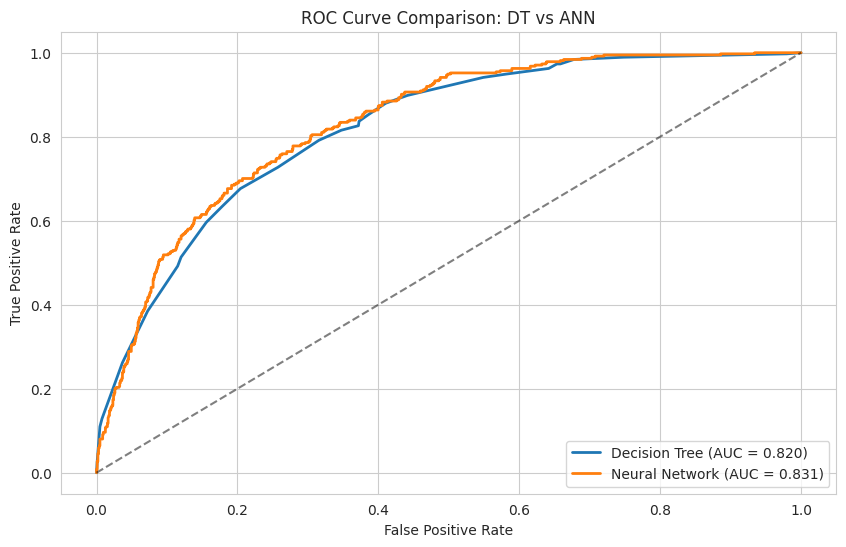


Final Comparison:
            Model  Accuracy   ROC AUC
0   Decision Tree  0.778252  0.819510
1  Neural Network  0.793888  0.830532


In [19]:
# Model Comparison & ROC Curves

# Calculate ROC Curves
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
roc_auc_dt = roc_auc_score(y_test, y_prob_dt)

fpr_ann, tpr_ann, _ = roc_curve(y_test, y_pred_ann_prob)
roc_auc_ann = roc_auc_score(y_test, y_pred_ann_prob)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.3f})', linewidth=2)
plt.plot(fpr_ann, tpr_ann, label=f'Neural Network (AUC = {roc_auc_ann:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5) # Random guess line

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: DT vs ANN')
plt.legend(loc="lower right")
plt.show()

# Final Metrics Summary Table
results = pd.DataFrame({
    'Model': ['Decision Tree', 'Neural Network'],
    'Accuracy': [accuracy_score(y_test, y_pred_dt), accuracy_score(y_test, y_pred_ann)],
    'ROC AUC': [roc_auc_dt, roc_auc_ann]
})

print("\nFinal Comparison:")
print(results)

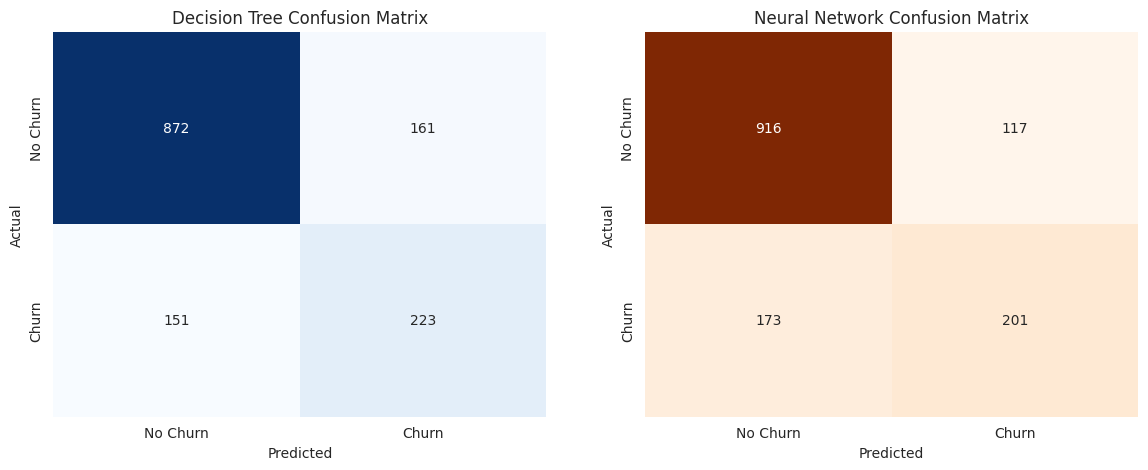

In [20]:
# Confusion Matrix Visualization

# 1. Calculate matrices
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_ann = confusion_matrix(y_test, y_pred_ann)

# 2. Plotting side-by-side
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Decision Tree Confusion Matrix
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', ax=ax[0], cbar=False)
ax[0].set_title('Decision Tree Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
ax[0].set_xticklabels(['No Churn', 'Churn'])
ax[0].set_yticklabels(['No Churn', 'Churn'])

# Neural Network Confusion Matrix
sns.heatmap(cm_ann, annot=True, fmt='d', cmap='Oranges', ax=ax[1], cbar=False)
ax[1].set_title('Neural Network Confusion Matrix')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
ax[1].set_xticklabels(['No Churn', 'Churn'])
ax[1].set_yticklabels(['No Churn', 'Churn'])

plt.show()